# Get started with circuit cutting using gate cuts

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=2.0.0
qiskit-ibm-runtime~=0.37.0
qiskit-aer~=0.17
qiskit-addon-cutting~=0.10.0
```
</details>

This guide demonstrates two working examples of gate cuts with the `qiskit-addon-cutting` package. The first example shows how to reduce circuit depth (the number of circuit instructions) by cutting entangling gates on non-adjacent qubits that would otherwise incur a SWAP overhead when transpiled to hardware. The second example covers how to use gate cutting to reduce the circuit width (the number of qubits) by splitting a circuit into several circuits with fewer qubits.

Both examples will use the [`efficient_su2`](/docs/api/qiskit/qiskit.circuit.library.efficient_su2) ansatz and reconstructs the same observable.

## Gate cutting to reduce circuit depth

The following workflow reduces a circuit's depth by cutting distant gates, avoiding a large series of SWAP gates that would otherwise be introduced.

Start with the [`efficient_su2`](/docs/api/qiskit/qiskit.circuit.library.efficient_su2) ansatz, with "circular" entanglement to introduce distant gates.

Observable: SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIXI', 'ZIZZ', 'IXIX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])


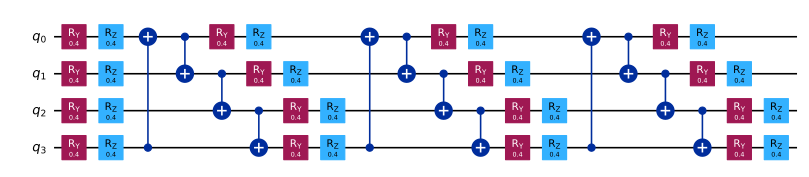

In [1]:
import numpy as np
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2, Batch
from qiskit_aer.primitives import EstimatorV2
from qiskit_addon_cutting import (
    cut_gates,
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

circuit = efficient_su2(num_qubits=4, entanglement="circular")
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)


observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
print(f"Observable: {observable}")
circuit.draw("mpl", scale=0.8)

Each of the [`CNOT`](/docs/api/qiskit/qiskit.circuit.library.CXGate) gates between qubits $q_0$ and $q_3$ introduce two SWAP gates after transpilation (assuming the qubits are connected in a straight line). To avoid this increase in depth, you can replace these distant gates with [`TwoQubitQPDGate`s](/docs/api/qiskit-addon-cutting/qpd-two-qubit-qpd-gate) using the [`cut_gates()`](/docs/api/qiskit-addon-cutting/qiskit-addon-cutting#cut_gates) method.  This function also returns a list of [`QPDBasis`](../api/qiskit-addon-cutting/qpd-qpd-basis) instances - one for each decomposition.

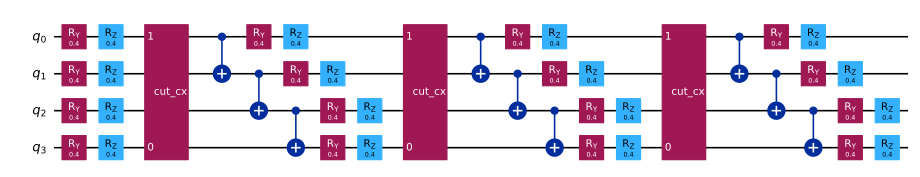

In [2]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)

qpd_circuit.draw("mpl", scale=0.8)

Now that the cut gate instructions have been added, the subexperiments will have a smaller depth after transpilation than the original circuit. The code snippet below generates the subexperiments using the [`generate_cutting_experiments`](/docs/api/qiskit-addon-cutting/qiskit-addon-cutting#generate_cutting_experiments), which ingests the circuit and observable to reconstruct.

<Admonition type="note" title="Note about the number of samples">
    The `num_samples` argument specifies how many samples to draw from the quasi-probability distribution and determines the accuracy of the coefficients used for the reconstruction. Passing infinity (`np.inf`) will ensure all coefficients are calculated exactly. Read the API docs on [generating weights](/docs/api/qiskit-addon-cutting/qpd#generate_qpd_weights) and [generating cutting experiments](/docs/api/qiskit-addon-cutting/qiskit-addon-cutting#generate_cutting_experiments) for more information.
</Admonition>

Once the subexperiments are generated, you can then transpile them and use the `Sampler` primitive to sample the distribution and reconstruct the estimated expectation values. The following code block generates, transpiles, and executes the subexperiments. It then reconstructs the results and compares them to the exact expectation value.

In [3]:
# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = pass_manager.run(subexperiments)

# Set up the Qiskit Runtime Sampler primitive, submit the subexperiments, and retrieve the results
sampler = SamplerV2(backend)
job = sampler.run(isa_subexperiments, shots=4096 * 3)
results = job.result()


# Reconstruct the results
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    observable.paulis,
)

# Apply the coefficients of the original observable
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

estimator = EstimatorV2()
exact_expval = (
    estimator.run([(circuit, observable, [0.4] * len(circuit.parameters))])
    .result()[0]
    .data.evs
)
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.44557699
Exact expectation value: 0.50497603
Error in estimation: -0.05939905
Relative error in estimation: -0.11762746


<Admonition type="caution" title="Note about observable coefficients">
    To accurately reconstruct the expectation value, the coefficients of the original observable (which are different from the coefficients in the output of `generate_cutting_experiments()`) must be applied to the output of the reconstruction, since this information was lost when the cutting experiments were generated or when the observable was expanded.

    Typically these coefficients can be applied through `numpy.dot()` as shown above.
</Admonition>

## Gate cutting to reduce circuit width

This section demonstrates using gate cutting to reduce circuit width. Start with the same [`efficient_su2`](/docs/api/qiskit/qiskit.circuit.library.efficient_su2) but use "linear" entanglement.

Observable: SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIXI', 'ZIZZ', 'IXIX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])


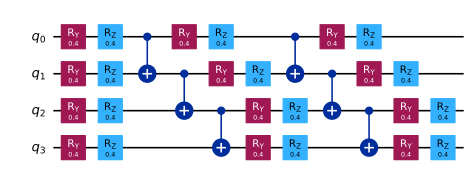

In [4]:
qc = efficient_su2(4, entanglement="linear", reps=2)
qc.assign_parameters([0.4] * len(qc.parameters), inplace=True)


observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
print(f"Observable: {observable}")

qc.draw("mpl", scale=0.8)

Then generate the *subcircuits* and *subobservables* you'll execute using the [`partition_problem()`](/docs/api/qiskit-addon-cutting/qiskit-addon-cutting#partition_problem) function. This function takes in the circuit, observable, and an optional partitioning scheme and returns the cut circuits and observables in the form of a dictionary.

The partitioning is defined by a label string of the form `"AABB"` where each label in this string corresponds to the qubit in the same index of the `circuit` argument. Qubits sharing a common partition label are grouped together, and any non-local gates that span more than one partition will be cut.

<Admonition type="information" title="Note">
   The `observables` kwarg to `partition_problem` is of type [`PauliList`](/docs/api/qiskit/qiskit.quantum_info.PauliList). Observable term coefficients and phases are ignored during decomposition of the problem and execution of the subexperiments. They may be re-applied during reconstruction of the expectation value.
</Admonition>

Sampling overhead: 81.0
Subobservables: {'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']), 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}


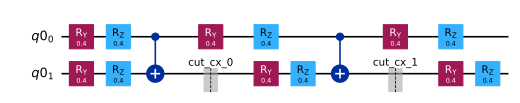

In [5]:
partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases


print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
print(f"Subobservables: {subobservables}")
subcircuits["A"].draw("mpl", scale=0.8)

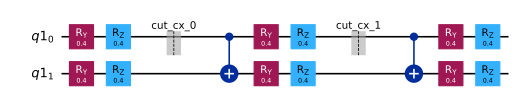

In [6]:
subcircuits["B"].draw("mpl", scale=0.8)

The next step is then to use the subcircuits and subobservables to generate the *subexperiments* to be executed on a QPU using the [`generate_cutting_experiments`](/docs/api/qiskit-addon-cutting/qiskit-addon-cutting#generate_cutting_experiments) method.

To estimate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasi-probability distribution and then executed on one or more QPUs. The number of samples to be taken from this distribution is controlled by the `num_samples` argument.

The following code block generates the subexperiments and executes them using the `Sampler` primitive on a local simulator. (To run these on a QPU, change the `backend` to your chosen QPU resource.)

In [7]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=4096 * 3)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

Lastly, the expectation value of the full circuit is reconstructed using the [`reconstruct_expectation_values`](/docs/api/qiskit-addon-cutting/qiskit-addon-cutting#reconstruct_expectation_values) method.

The code block below reconstructs the results and compares them with the exact expectation value.

In [8]:
# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)


estimator = EstimatorV2()
exact_expval = (
    estimator.run([(qc, observable, [0.4] * len(qc.parameters))])
    .result()[0]
    .data.evs
)
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.52049261
Exact expectation value: 0.56254612
Error in estimation: -0.04205351
Relative error in estimation: -0.07475567


## Next steps

<Admonition type="tip" title="Recommendations">
    - Read the [Get started with circuit cutting using wire cuts](/docs/guides/qiskit-addons-cutting-wires) guide.
    - Read the arXiv paper on [circuit knitting with classical communication.](https://ieeexplore.ieee.org/document/10236453)
</Admonition>